In [2]:
import torch
from torch.distributions import Uniform
import matplotlib.pyplot as plt
import numpy as np

In [95]:
class CellPopulation:
    """
    Popolazione di cellule contenente:
      - self.states: tensor [N, F] con i parametri interni di ciascuna cellula
      - self.ids:    tensor [N] con un identificatore univoco per ogni cellula
      - self.next_id: intero, prossimo ID da assegnare
    """
    def __init__(self, 
                N0: int, 
                e_cntr: int, 
                f_cntr: int, 
                dupl_thrs :int, 
                k_cat: float,
                device=None
                ):

        self.device  = device or torch.device('cpu')
        self.N       = N0          
        self.ids  = torch.arange(N0, dtype=torch.int64) # [N0]
        self.enzyme_cntr = Uniform(0.01*e_cntr, 100*e_cntr).sample((N0,)).to(dtype=torch.float32, device=self.device)  # torch.full((N0,), e_cntr, dtype=torch.float32) # [N0]
        self.dupl_thrs = dupl_thrs

        self.food_cntr = torch.full((N0,), f_cntr, dtype=torch.float32) # [N0] Uniform(0.0, self.dupl_thrs).sample((N0,)).to(dtype=torch.float32, device=self.device)  #
        self.K_cat = k_cat
        self.Ns = torch.tensor([N0], dtype=torch.int64, device=self.device)  # [1] per tenere traccia del numero di cellule in ogni passo
        self.e_distrib = [self.enzyme_cntr]




    @torch.no_grad()
    def food_gain(self):
        """
        Calcola il guadagno di cibo per ogni cellula:
        """
        self.food_cntr += self.K_cat * self.enzyme_cntr # [N]
        return 

    @torch.no_grad()
    def duplication(self):
        """
        Duplicazione delle cellule:
        """
        dupl_mask = self.food_cntr >= self.dupl_thrs # [N]
        new_cells_num = dupl_mask.sum().item()
        growth_rate = new_cells_num /self.N

        self.N += new_cells_num  # Aggiorna il numero di cellule
        self.food_cntr[dupl_mask] -= self.dupl_thrs #0.0  # Resetta il contatore dell'enzima per le cellule che duplicano

        cloned_e_cntr = self.enzyme_cntr[dupl_mask].clone()  # Crea una maschera per le cellule da clonare
        self.enzyme_cntr = torch.cat([self.enzyme_cntr, cloned_e_cntr], dim=0)  # Aggiungi i nuovi enzimi
        self.food_cntr = torch.cat([self.food_cntr, self.food_cntr[dupl_mask]], dim=0)  # torch.zeros(new_cells_num, dtype=self.food_cntr.dtype) Aggiungi i nuovi contatori di cibo

        return growth_rate

    @torch.no_grad()
    def mok_duplication(self):
        """
        Duplicazione delle cellule:
        """
        dupl_mask = self.food_cntr >= self.dupl_thrs # [N]
        growth_rate = dupl_mask.item()
        self.food_cntr[dupl_mask] -= self.dupl_thrs #0.0  # Resetta il contatore dell'enzima per le cellule che duplicano
        return growth_rate



    @torch.no_grad()
    def step(self):
        """
        Esegue un passo di simulazione:
        """
        self.food_gain()
        growth_rate = self.duplication()
        self.Ns = torch.cat([self.Ns, torch.tensor([self.N], dtype=torch.int64, device=self.device)])
        self.e_distrib.append(self.enzyme_cntr)  # Aggiungi la distribuzione degli enzimi alla lista
        return growth_rate

    @torch.no_grad()
    def mok_step(self):
        """
        Esegue un passo di simulazione:
        """
        self.food_gain()
        growth_rate = self.mok_duplication()
        return growth_rate

    

    def simulate(self, steps: int):
        """
        Esegue una simulazione per un numero di passi specificato.
        """
        growth_rates = torch.zeros(steps, dtype=torch.float32)
        for i in range(steps):
            # print(f"Step {i+1}/{steps}: N = {self.N}")
            growth_rates[i] = self.step()
        return growth_rates

    def mok_simulate(self, steps: int):
        """
        Esegue una simulazione per un numero di passi specificato.
        """
        growth_rates = torch.zeros(steps, dtype=torch.float32)
        for i in range(steps):
            # print(f"Step {i+1}/{steps}: N = {self.N}")
            growth_rates[i] = self.mok_step()
        return growth_rates

    # @property
    # def ave_e_cntr(self):
    #     return self.enzyme_cntr.mean()

    # @property
    # def ave_f_cntr(self):
    #     return self.food_cntr.mean()

    # @property
    # def ave_f_cntr(self):
    #     return self.food_cntr.mean()



Step 1/100: k_cat = 100, mu = 0.0, N = 100
Step 2/100: k_cat = 113, mu = 0.0, N = 100
Step 3/100: k_cat = 129, mu = 0.0, N = 100
Step 4/100: k_cat = 147, mu = 0.0, N = 100
Step 5/100: k_cat = 167, mu = 0.0, N = 100
Step 6/100: k_cat = 190, mu = 0.0, N = 100
Step 7/100: k_cat = 216, mu = 0.0, N = 100
Step 8/100: k_cat = 246, mu = 0.0, N = 100
Step 9/100: k_cat = 280, mu = 0.01, N = 112
Step 10/100: k_cat = 319, mu = 0.01, N = 114
Step 11/100: k_cat = 363, mu = 0.01, N = 132
Step 12/100: k_cat = 413, mu = 0.02, N = 137
Step 13/100: k_cat = 469, mu = 0.02, N = 135
Step 14/100: k_cat = 534, mu = 0.03, N = 163
Step 15/100: k_cat = 608, mu = 0.04, N = 203
Step 16/100: k_cat = 691, mu = 0.04, N = 197
Step 17/100: k_cat = 787, mu = 0.04, N = 233
Step 18/100: k_cat = 895, mu = 0.06, N = 323
Step 19/100: k_cat = 1018, mu = 0.08, N = 431
Step 20/100: k_cat = 1158, mu = 0.09, N = 522
Step 21/100: k_cat = 1318, mu = 0.11, N = 816
Step 22/100: k_cat = 1499, mu = 0.13, N = 1085
Step 23/100: k_cat = 1

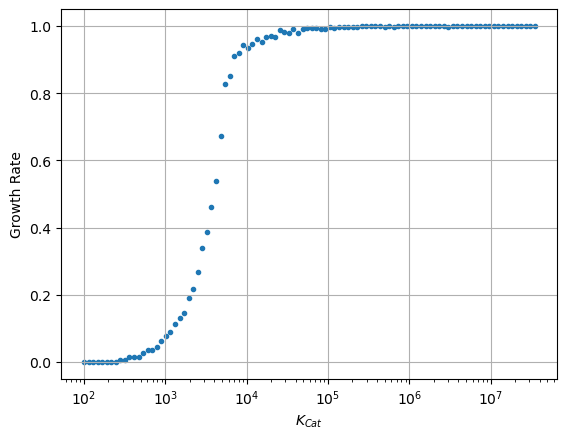

In [76]:
N0 = 100  # Numero iniziale di cellule
e_cntr = 0.00000002  # Contatore iniziale di enzimi
f_cntr = 0.00001  # Contatore iniziale di cibo
dupl_thrs = 0.01  # Soglia di duplicazione



# Ks = np.arange(0.0, 35000000, 500000).tolist()
# Estremi dell'intervallo logaritmico (min > 0)
start = 1e2            # oppure un altro minimo, ad es. 1e1 o 1e2
end = 3.5e7
num_points = 100        # numero di punti desiderati

# Spaziatura logaritmica
Ks = np.logspace(np.log10(start), np.log10(end), num=num_points).tolist()

rates = []
c = 0
for k in Ks: 
    c+=1
    
    population = CellPopulation(N0, e_cntr, f_cntr, dupl_thrs, k)
    growth_rates = population.simulate(steps=20)
    print(f"Step {c}/{len(Ks)}: k_cat = {int(k)}, mu = {np.round(growth_rates.mean().item(), 2)}, N = {population.N}")
    rates.append(growth_rates.mean().item())
   

plt.scatter(Ks, rates, marker=".")
plt.xscale("log")
plt.xlabel(r"$K_{Cat}$")
plt.ylabel("Growth Rate")
plt.grid(True)

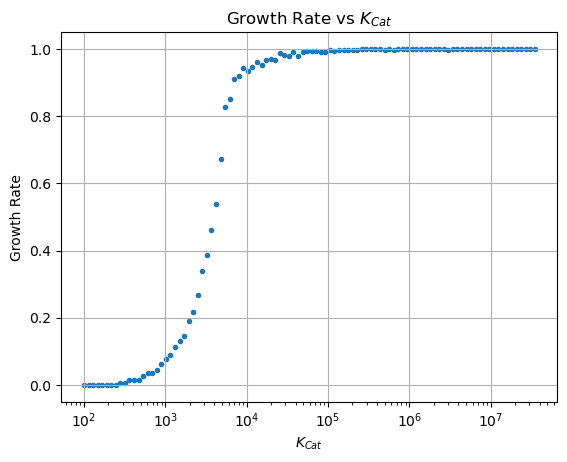

In [ ]:
plt.title("Growth Rate vs $K_{Cat}$")
plt.scatter(Ks, rates, marker=".")
plt.xscale("log")
plt.xlabel("$K_{Cat}$")
plt.ylabel("Growth Rate")
plt.grid(True)
plt.savefig("food_doesNOT_goes_to_zero_(e in [0.01, 100] * e_cntr).png")
plt.show()

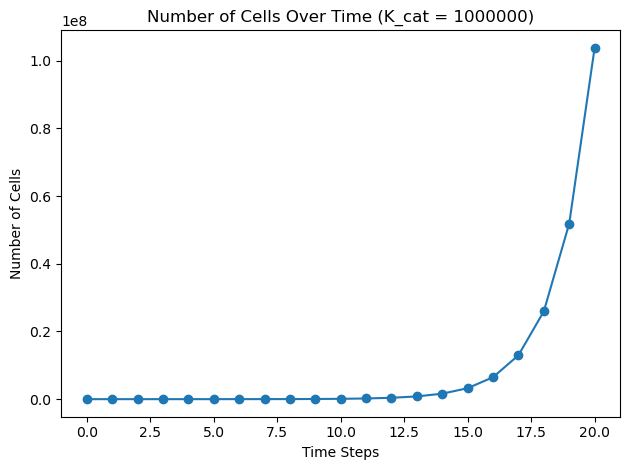

In [151]:
k = 1_000_000
f_cntr = 0.00001
e_cntr = 0.00000002

population = CellPopulation(N0, e_cntr, f_cntr, dupl_thrs, k)
growth_rates = population.simulate(steps=20)
plt.figure()
plt.title(f"Number of Cells Over Time (K_cat = {k})")
plt.plot(population.Ns.cpu().numpy(), marker="o")
plt.xlabel("Time Steps")
plt.ylabel("Number of Cells")
plt.tight_layout()
plt.savefig(f"noise_e/number_cells_K={k}.png")
plt.show()

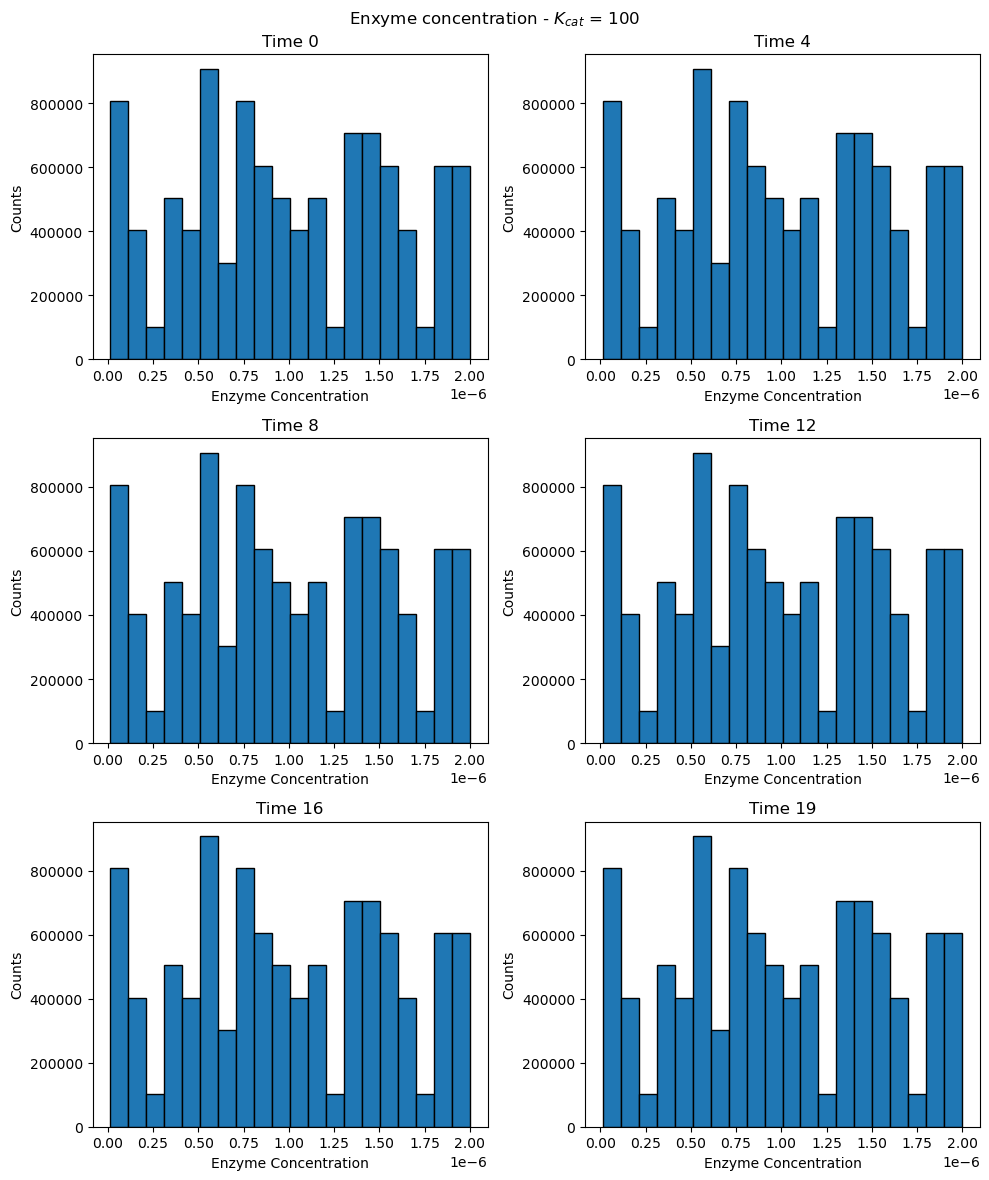

In [143]:
import matplotlib.pyplot as plt

# Supponiamo che tu abbia i tempi salvati in questa lista
tempi = [0, 4, 8, 12, 16, 19]  # puoi modificare questa lista come preferisci

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
plt.suptitle("Enxyme concentration - " + r"$K_{cat}$" + f" = {k}")
for i, t in enumerate(tempi):
    row, col = divmod(i, 2)
    axs[row, col].hist(population.e_distrib[t].cpu(), bins=20, edgecolor='black', density=True)
    axs[row, col].set_title(f"Time {t}")
    axs[row, col].set_xlabel("Enzyme Concentration")
    axs[row, col].set_ylabel("Counts")

plt.tight_layout()
plt.savefig(f"enzyme_concentration_K={k}.png")
plt.show()